# Explore Topic Models
Explores the topic models of forum posts with LDA (Latent Dirichlet Allocation)

## TODO
- Tutorial
 - https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
 - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python


## Imports

In [151]:
from gensim import corpora, models
import pickle
from pathlib import Path
from io import FileIO
import pyLDAvis.gensim
from gensim.models import LdaModel, LdaMulticore
from lemmatize import *
from scraping import create_connection


In [152]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Functions

In [153]:
def load_data(forum="all", group="all", id_type="family_id"):
    lemmatized_text = pickle.load(open(path_lemma_pkl.format(forum, group, id_type), 'rb'))
    corpus = pickle.load(open(path_corpus_pkl.format(forum, group, id_type), 'rb'))
    dictionary = corpora.Dictionary.load(path_dictionary_gensim.format(forum, group, id_type))
    return lemmatized_text, corpus, dictionary

In [154]:
def gen_cols(n):
    return ["topic_{}".format(str(i).zfill(2)) for i in range(n)]

## File Locations

In [155]:
p = Path.cwd()
path_parent = p.parents[0]

In [156]:
# database
path_db = str(path_parent / "database" / "youbemom-merged.db")
# data to load
path_lemma_pkl = str(path_parent / "clean_data" / "lemmatized_text_{0}_{1}_{2}.pkl")
path_corpus_pkl = str(path_parent / "clean_data" / "corpus_{0}_{1}_{2}.pkl")
path_dictionary_gensim = str(path_parent / "clean_data" / "dictionary_{0}_{1}_{2}.gensim")
# model saving
path_tune_models = str(path_parent / "clean_data" / "lda_tune_{0}_{1}_{2}_{3}_{4}.gensim")
path_ntopic_models = str(path_parent / "clean_data" / "lda_ntopics_{0}_{1}_{2}_{3}.gensim")
# path_coherence = str(path_parent / "clean_data" / "coherence_{}.csv")
path_log = str(path_parent / "clean_data" / "logging_{0}_{1}_{2}_{3}.log")
path_log_iterations = str(path_parent / "clean_data" / "logging_{0}_{1}_{2}_{3}.log")
# dominant topic
path_dom_topic = str(path_parent / "clean_data" / "dominant_topic_{0}_{1}_{2}_{3}.csv")
# clean text
path_clean_text = str(path_parent / "clean_data" / "clean_text_{0}_{1}.csv")

## Load Data

In [157]:
args = {
    'special-needs':{'n_passes':100, 'n_iterations':200, 'n_topics':[5, 10, 15, 20, 25, 30, 40, 50]},
    'tween-teen':   {'n_passes':120, 'n_iterations':400, 'n_topics':[2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 40, 50]},
    'preschool':    {'n_passes':100, 'n_iterations':400, 'n_topics':[2, 3, 4, 5, 7, 10, 15, 20, 25, 30]},
    'elementary':   {'n_passes':130, 'n_iterations':400, 'n_topics':[2, 3, 4, 5, 7, 10, 15, 20, 25, 30]},
    'new-york-city':{'n_passes':150, 'n_iterations':400, 'n_topics':[2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 40, 50]},
    'school':       {'n_passes':200, 'n_iterations':400, 'n_topics':[2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 40, 50]},
    'toddler':      {'n_passes':35,  'n_iterations':200, 'n_topics':[5, 10, 15, 20, 25, 30, 40, 50]}
}

In [158]:
sf = "special-needs"
n = 20

In [159]:
group = 'all'
id_type = 'family_id'

In [160]:
lemmatized_text, corpus, dictionary = load_data(sf, group, id_type)

In [161]:
mod_dict = {}
for i in args[sf]["n_topics"]:
    mod_dict[str(i)] = LdaModel.load(path_ntopic_models.format(sf, group, id_type, str(i)))

In [162]:
date_sql = '''
    SELECT family_id, message_id, date_created
    FROM posts
    WHERE subforum=?
        AND parent_id=""
'''

In [163]:
# sen_sql = '''
#     SELECT s.message_id, s.com_sen_clean
#     FROM sentiment AS s
#     LEFT JOIN posts AS p
#         ON s.message_id = p.message_id
#     WHERE p.subforum=?
# '''

In [198]:
conn = create_connection(path_db)
dates = pd.read_sql(date_sql, conn, params=(sf,))
# sen = pd.read_sql(sen_sql, conn, params=(sf,))

In [199]:
dates = dates.drop('message_id', axis=1)
# sen['message_id'] = pd.to_numeric(sen['message_id'])

In [200]:
clean_text = pd.read_csv(path_clean_text.format(sf, group))
# clean_text = clean_text.merge(sen, how="left", on="message_id")

In [201]:
text = clean_text[['family_id','text_clean']].groupby(['family_id'])['text_clean'].apply(' '.join)
text = text.to_frame()
text.reset_index(inplace=True)

In [202]:
dates_merged = text.merge(dates, how="left", on="family_id")

In [203]:
dates_merged.shape

(25461, 3)

In [204]:
dates_merged['date_created'] = pd.to_datetime(dates_merged['date_created'])

In [206]:
out = np.zeros((len(corpus), n), dtype=float, order='C')
for i, doc in enumerate(corpus):
    topics = mod_dict[str(n)].get_document_topics(doc)
    for j, score in topics:
        out[i,j] = score

In [208]:
dates_merged.reset_index(drop=True, inplace=True)

In [209]:
cols = gen_cols(n)
df = pd.concat([dates_merged, pd.DataFrame(out, columns=cols)], axis=1)

In [210]:
df = df[(df['date_created'] < pd.to_datetime('2021-01-01'))]

In [212]:
df = df.set_index(['date_created'])

In [213]:
weeks = df[cols].groupby(pd.Grouper(freq='W')).sum()
weeks['total'] = weeks[cols].sum(axis=1)
weeks[cols] = weeks[cols].div(weeks["total"], axis=0)

In [214]:
months = df[cols].groupby(pd.Grouper(freq='M')).sum()
months['total'] = months[cols].sum(axis=1)
months[cols] = months[cols].div(months["total"], axis=0)
cummonth = months[cols].cumsum(axis=1)

In [215]:
path_data = str(path_parent / "clean_data" / "clean_data_{}_{}_{}_{}_{}.csv")
months.to_csv(path_data.format(sf, group, id_type, str(n), "month"), index=True)

In [216]:
weeks.to_csv(path_data.format(sf, group, id_type, str(n), "week"), index=True)

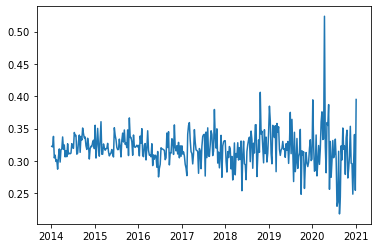

In [224]:
import matplotlib.pyplot as plt
plt.plot(weeks.index, weeks['topic_09'])

In [ ]:
clean_text.to_csv(path_data.format(sf, group, id_type, str(n), "sen"), index=False)

In [26]:
def hex(h):
    return "#" + h

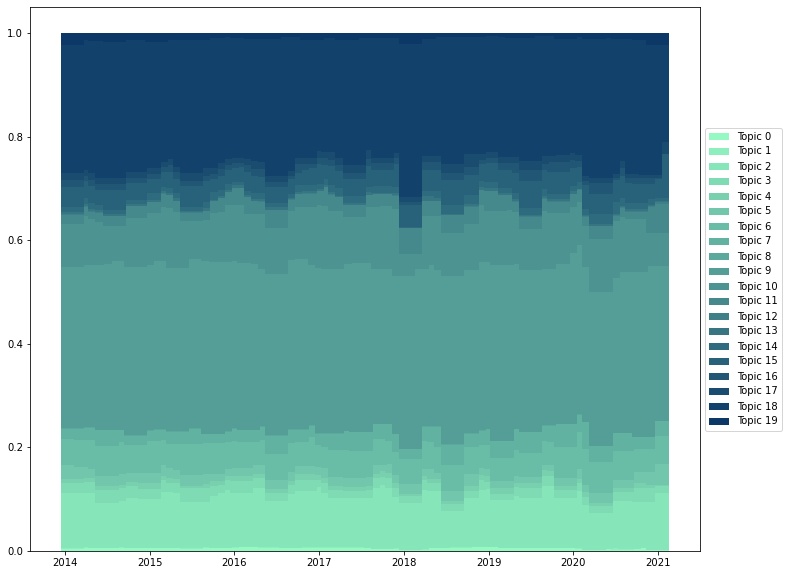

In [27]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
fig, ax = plt.subplots()
width = 0.35
colors = ["95F9C3","8EEFBE","86E5B9","7FDBB4","78D0AF","71C6AB","69BCA6","62B2A1","5BA89C","549E97","4C9392","45898D","3E7F88","377583","2F6B7E","28617A","215675","1A4C70","12426B","0B3866"]
ax.bar(months.index, months[cols[0]], width=100, label='Topic {}'.format(0), color=hex(colors[0]))
for i in range(1, n):
    ax.bar(months.index, months[cols[i]], bottom=cummonth[cols[i-1]], width=100, label='Topic {}'.format(i), color=hex(colors[i]))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_size_inches(12, 10)
fig.savefig(path_parent / "plots" / "topic_distribution_{}_{}.png".format(sf, str(n)))

In [29]:
c = df[cols].corr()

In [31]:
c

,topic_00,topic_01,topic_02,topic_03,topic_04,topic_05,topic_06,topic_07,topic_08,topic_09,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
topic_00,1.000000,0.015159,-0.150680,-0.061452,-0.067037,0.029273,0.082457,-0.061036,0.013256,0.168998,-0.150850,0.244460,0.034674,-0.037426,-0.061846,-0.056844,-0.054092,-0.024198,-0.075254,-0.044866
topic_01,0.015159,1.000000,-0.015622,-0.015912,0.038076,0.001003,0.014101,0.000189,0.000068,-0.043640,-0.033486,-0.016615,0.010395,0.005832,0.035632,0.030137,-0.003575,-0.014249,0.019317,-0.009596
topic_02,-0.150680,-0.015622,1.000000,-0.047001,0.053890,-0.020364,-0.214404,-0.104158,-0.024904,-0.330765,0.005522,-0.175213,-0.037921,0.115719,0.052833,-0.059569,0.119258,-0.101543,-0.323050,0.086688
topic_03,-0.061452,-0.015912,-0.047001,1.000000,0.035480,-0.067161,-0.118574,-0.070266,0.006225,-0.037337,-0.062435,-0.054129,-0.010205,0.052188,-0.072152,-0.015358,-0.086383,0.039458,-0.012815,0.062855
topic_04,-0.067037,0.038076,0.053890,0.035480,1.000000,-0.066767,-0.070311,0.017857,0.016233,-0.039021,0.042161,-0.089112,-0.009211,0.063710,-0.033954,0.033880,-0.035126,-0.057354,-0.119774,-0.023339
topic_05,0.029273,0.001003,-0.020364,-0.067161,-0.066767,1.000000,0.014423,-0.038376,-0.009091,-0.055128,-0.123505,-0.025858,-0.006039,-0.017172,0.018604,-0.020714,0.033772,-0.057246,-0.038903,0.025737
topic_06,0.082457,0.014101,-0.214404,-0.118574,-0.070311,0.014423,1.000000,-0.011864,-0.002221,0.070226,-0.272353,-0.116629,0.038748,-0.077632,-0.083688,-0.118766,-0.107609,-0.071107,0.094234,-0.079361
topic_07,-0.061036,0.000189,-0.104158,-0.070266,0.017857,-0.038376,-0.011864,1.000000,0.015477,-0.106377,0.044363,-0.127707,0.019105,-0.007719,-0.002521,0.043721,-0.067285,-0.055903,-0.076869,-0.048815
topic_08,0.013256,0.000068,-0.024904,0.006225,0.016233,-0.009091,-0.002221,0.015477,1.000000,-0.026666,-0.030919,-0.021522,0.042332,-0.011746,0.026601,0.090722,-0.014624,0.005500,-0.027881,-0.003882
topic_09,0.168998,-0.043640,-0.330765,-0.037337,-0.039021,-0.055128,0.070226,-0.106377,-0.026666,1.000000,-0.373318,0.329902,-0.030636,-0.056662,-0.228125,-0.232411,-0.215625,0.071981,-0.221717,-0.079742


In [ ]:
# ones = df[cols].apply(np.ceil)
# c = ones[cols].corr()

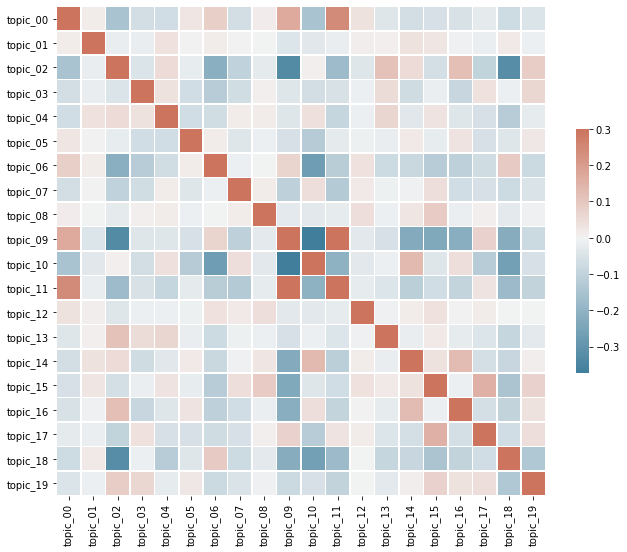

In [30]:
import seaborn as sns
# mask = np.triu(np.ones_like(c, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(c, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig(path_parent / "plots" / "topic_corr_{}_{}.png".format(sf, str(n)))

In [ ]:
df_sen = df.merge(clean_text[['message_id','com_sen_clean']], on="message_id", how="left")

In [ ]:
df_sen['topic'] = df_sen[cols].idxmax(axis=1)

In [ ]:
g = sns.boxplot(x="topic", y="com_sen_clean", data=df_sen, width=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [ ]:
df_sen.groupby('topic')['com_sen_clean'].mean()

## Toddler

In [ ]:
sf = "toddler"
n = 15

In [ ]:
lemmatized_text, corpus, dictionary = load_data(sf, group, id_type)

In [ ]:
mod_dict = {}
for i in args[sf]["n_topics"]:
    mod_dict[str(i)] = LdaModel.load(path_ntopic_models.format(sf, group, id_type, str(i)))

In [ ]:
clean_text = pd.read_csv(path_clean_text.format(sf, group))
temp = clean_text[['family_id']]
temp.to_sql("temp", conn, if_exists='replace')

In [ ]:
date_sql = '''
    SELECT family_id, message_id, date_created
    FROM posts
    WHERE subforum=?
        AND parent_id=""
        AND family_id IN (SELECT family_id FROM temp)
'''

In [ ]:
dates = pd.read_sql(date_sql, conn, params=(sf,))

In [ ]:
text = clean_text[['family_id','text_clean']].groupby(['family_id'])['text_clean'].apply(' '.join)
text = text.to_frame()
text.reset_index(inplace=True)
df = text.merge(dates, how="right", on="family_id")
df['date_created'] = pd.to_datetime(df['date_created'])
out = np.zeros((len(corpus), n), dtype=float, order='C')
for i, doc in enumerate(corpus):
    topics = mod_dict[str(n)].get_document_topics(doc)
    for j, score in topics:
        out[i,j] = score
cols = gen_cols(n)
df = pd.concat([df, pd.DataFrame(out, columns=cols)], axis=1)
df = df.set_index(['date_created'])
weeks = df[cols].groupby(pd.Grouper(freq='W')).sum()
weeks['total'] = weeks[cols].sum(axis=1)
months = df[cols].groupby(pd.Grouper(freq='M')).sum()
months['total'] = months[cols].sum(axis=1)
months[cols] = months[cols].div(months["total"], axis=0)
cummonth = months[cols].cumsum(axis=1)
months.to_csv(path_data.format(sf, group, id_type, str(n), "month"), index=False)
weeks.to_csv(path_data.format(sf, group, id_type, str(n), "week"), index=False)

In [ ]:
colsums = pd.DataFrame(out).sum()
totalsum = colsums.sum()
100 * colsums / totalsum

In [ ]:
df.to_csv(path_data.format(sf, group, id_type, str(n), "df"), index=False)

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
fig, ax = plt.subplots()
width = 0.35
colors = ["95F9C3","8EEFBE","86E5B9","7FDBB4","78D0AF","71C6AB","69BCA6","62B2A1","5BA89C","549E97","4C9392","45898D","3E7F88","377583","2F6B7E","28617A","215675","1A4C70","12426B","0B3866"]
ax.bar(months.index, months[cols[0]], width=100, label='Topic {}'.format(0), color=hex(colors[0]))
for i in range(1, n):
    ax.bar(months.index, months[cols[i]], bottom=cummonth[cols[i-1]], width=100, label='Topic {}'.format(i), color=hex(colors[i]))
# ax.bar(months.index, women_means, width, yerr=women_std, bottom=men_means,
#        label='Women')
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_size_inches(12, 10)
fig.savefig(path_parent / "plots" / "topic_distribution_{}_{}.png".format(sf, str(n)))

## Visualize Topics

In [ ]:
pyLDAvis.display(pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False))

## Most Representative Post for Each Topic

In [ ]:
topic_sentences = format_topics_sentences(ldamodel, corpus)

In [ ]:
topic_sentences.info()

In [ ]:
df_joined = pd.concat([df.reset_index(drop=True), topic_sentences.reset_index(drop=True)], axis=1)

In [ ]:
df_joined.to_csv(path_topic.format('special-needs', 'all'), sep='\t', index=False)

In [ ]:
topic_dominant = pd.DataFrame()
topic_grouped = df_joined.groupby('Dominant_Topic')
for i, grp in topic_grouped:
    topic_dominant = pd.concat([topic_dominant,
                                grp.sort_values(['Perc_Contribution'],
                                                ascending=[0]).head(3)],
                               axis=0)
topic_dominant.reset_index(drop=True, inplace=True)
topic_dominant.info()

In [ ]:
for t in topic_dominant['text_clean']:
    print(t)